In [1]:
%matplotlib inline
import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('ticks',
              {'grid.linestyle': 'none', 'axes.edgecolor': '0',
               'axes.linewidth': 1.2, 'legend.frameon': True,
               'xtick.direction': 'out', 'ytick.direction': 'out',
               'xtick.top': True, 'ytick.right': True,
              })

In [2]:
import pysixtrack
import sixtracklib as stl
import numpy as np
from termcolor import colored

from cpymad.madx import Madx

## MAD-X part first

In [3]:
madx = Madx()
madx.options.echo = False #True
madx.options.warn = False #True
madx.options.info = False #True


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2023.03.15 14:14:08      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [4]:
madx.call('./SIS18RING.SEQ')

In [5]:
# Define SIS18 Ar18+ beam in MAD-X:

In [6]:
from mainvalues import *
print (' element = Ar, mass = {:d} amu, charge = {:d} e, Ekin = {:.0f} MeV/u'.format(
   A, Q, 1e-6 * Ekin_per_nucleon))

 element = Ar, mass = 40 amu, charge = 18 e, Ekin = 500 MeV/u


In [7]:
madx.command.beam(particle='ion', mass=A*nmass, charge=Q, energy=Etot, pc=0.0001);
print (madx.command.beam)

beam, particle=positron, bunched=true, radiate=false, mass=0.00051099895, charge=1.0, energy=1.0, pc=0.0, gamma=0.0, beta=0.0, brho=0.0, ex=1.0, exn=0.0, ey=1.0, eyn=0.0, et=0.001, sigt=1.0, sige=0.001, kbunch=1.0, npart=1.0, bcurrent=0.0, freq0=0.0, circ=0.0, dtbyds=0.0, deltap=0.0, alfa=0.0, u0=0.0, qs=0.0, arad=0.0, bv=1.0, pdamp={1.0,1.0,2.0}, n1min=-1.0;


In [15]:
#add quadrupoles

madx.input('''
            k1nl_GS01QS1F:=kqf;
            k1nl_GS01QS2D:=kqd;
            k1nl_GS12QS1F:=kqf;
            k1nl_GS12QS2D:=kqd;
            k1nl_GS12QS3T:=kqt;
            kqd := -0.351510175975;
            kqf := 0.372244563766;
            kqt := 0.0315;
        ''');

In [16]:
#add sextupoles

madx.input('''
            k2nl_GS01KS1C:=ks11;
            k2nl_GS01KS3C:=ks3;
            k2nl_GS03KS1C:=ks31;
            k2nl_GS03KS3C:=ks3;
            k2nl_GS05KS1C:=ks51;
            k2nl_GS05KS3C:=ks3;
            k2nl_GS07KS1C:=ks71;
            k2nl_GS07KS3C:=ks3;
            k2nl_GS09KS1C:=ks91;
            k2nl_GS09KS3C:=ks3;
            k2nl_GS11KS1C:=ks111;
            k2nl_GS11KS3C:=ks3;
            ks11:=0.05*sin((0.0/6.0*2*pi)+(19.999998606995931*pi/180));
            ks31:=0.05*sin((1.0/6.0*2*pi)+(19.999998606995931*pi/180));
            ks51:=0.05*sin((2.0/6.0*2*pi)+(19.999998606995931*pi/180));
            ks71:=0.05*sin((3.0/6.0*2*pi)+(19.999998606995931*pi/180));
            ks91:=0.05*sin((4.0/6.0*2*pi)+(19.999998606995931*pi/180));
            ks111:=0.05*sin((5.0/6.0*2*pi)+(19.999998606995931*pi/180));
            ks3:=0.0;
''')

True

In [17]:
# add momentum spread

# madx.input('''
# deltap=5.0e-4;
# ''');

In [18]:
# add es & mg bumps

#madx.input('''
#k0nl_GS04MU1A:=-0.15*0.0018;
#k0nl_GS05MU2A:=-1.04*0.0018;
#k0nl_GS06MU1A:=2.68*0.0006;
#k0nl_GS07MU2A:=2.42*0.0006;
#''')

In [19]:
madx.use(sequence='sis18ring')

assert madx.command.select(
    flag='MAKETHIN',
    class_='QUADRUPOLE',
    slice_='9',
)

assert madx.command.select(
    flag='MAKETHIN',
    class_='SBEND',
    slice_='9',
)

assert madx.command.makethin(
    makedipedge=True,
    style='teapot',
    sequence='SIS18RING',
)

makethin: style chosen : teapot
makethin: slicing sequence : sis18ring


In [20]:
# Match tunes to Q_x=4.325, Q_y=3.29:

In [21]:
madx.use(sequence='sis18ring')

madx.input('''
match, sequence=SIS18RING;
global, sequence=SIS18RING, q1=4.3330, q2=3.29;
vary, name=kqf, step=0.001;
vary, name=kqd, step=0.001;
lmdif, calls=20000, tolerance=1.0e-8;
endmatch;
''');

START MATCHING

number of sequences: 1
sequence name: sis18ring
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:

Initial Penalty Function =   0.18665095E+00


call:       4   Penalty function =   0.17662614E-04
call:       7   Penalty function =   0.23398713E-11
 ++++++++++ LMDIF ended: converged successfully
call:       7   Penalty function =   0.23398713E-11

MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------
Global constraint:         q1           4     4.33300000E+00     4.33300015E+00     2.33983700E-12
Global constraint:         q2           4     3.29000000E+00     3.29000000E+00     3.42775518E-17


Final Penalty Function =   2.33987127e-12





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
-------------------------------------------------------------

In [22]:
# madx.use(sequence='sis18ring')

#madx.input('''
#use, sequence=SIS18RING, period=x, range=-0.01,0.01, survey=logical;
#''');

In [23]:
twiss = madx.twiss();

print ('\nQ1 = {:.2f} and Q2 = {:.2f}'.format(
    twiss.summary['q1'], twiss.summary['q2']))

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
            216.72                 -0      0.03126234459        5.655737276 

                q1                dq1            betxmax              dxmax 
       4.333000153       -9.012347379         31.8627484        4.295181041 

             dxrms             xcomax             xcorms                 q2 
       2.350227999                  0                  0        3.289999999 

               dq2            betymax              dymax              dyrms 
      -5.535016665        23.75346739                 -0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

## Now transfer SIS100 lattice to `PySixTrack`

In [24]:
pysixtrack_elements = pysixtrack.Line.from_madx_sequence(
    madx.sequence.sis18ring, 
    exact_drift=True, install_apertures=False,
)

`pysixtrack_elements.elements` is a python list, we can play with it...

In [25]:
pysixtrack_elements.elements

[DriftExact(length=0.0),
 DriftExact(length=0.0),
 DriftExact(length=0.0),
 DriftExact(length=0.1106670933),
 DriftExact(length=0.0),
 DriftExact(length=0.11066709324999992),
 DipoleEdge(h=0.09606147934639933, e1=0.1308996938995747, hgap=0.045, fint=0.35),
 DriftExact(length=0.06813329067500007),
 Multipole(knl=[0.014544410433286078, 0.0, 0.0, 0.0], ksl=[0.0], hxl=0.014544410433286078, hyl=0.0, length=0.15140731261111112),
 DriftExact(length=0.15329990401874993),
 Multipole(knl=[0.014544410433286078, 0.0, 0.0, 0.0], ksl=[0.0], hxl=0.014544410433286078, hyl=0.0, length=0.15140731261111112),
 DriftExact(length=0.15329990401875004),
 Multipole(knl=[0.014544410433286078, 0.0, 0.0, 0.0], ksl=[0.0], hxl=0.014544410433286078, hyl=0.0, length=0.15140731261111112),
 DriftExact(length=0.15329990401874993),
 Multipole(knl=[0.014544410433286078, 0.0, 0.0, 0.0], ksl=[0.0], hxl=0.014544410433286078, hyl=0.0, length=0.15140731261111112),
 DriftExact(length=0.15329990401875004),
 DriftExact(length=0.0

## Finally go to `SixTrackLib`

Transfer lattice from `PySixTrack`:

In [26]:
elements = stl.Elements.from_line(pysixtrack_elements)

nturns = 2**10
elements.BeamMonitor(num_stores=nturns);

And define particle set:

In [27]:
npart = 15
particles = stl.Particles.from_ref(npart, p0c=p0c)
particles.x += np.linspace(0, 1e-3, npart, endpoint=False)
particles.x += particles.x[1]
print (particles)

<Particles at 128
  num_particles:15
  q0:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  mass0:[9.38272081e+08 9.38272081e+08 9.38272081e+08 9.38272081e+08
 9.38272081e+08 9.38272081e+08 9.38272081e+08 9.38272081e+08
 9.38272081e+08 9.38272081e+08 9.38272081e+08 9.38272081e+08
 9.38272081e+08 9.38272081e+08 9.38272081e+08]
  beta0:[0.99976723 0.99976723 0.99976723 0.99976723 0.99976723 0.99976723
 0.99976723 0.99976723 0.99976723 0.99976723 0.99976723 0.99976723
 0.99976723 0.99976723 0.99976723]
  gamma0:[46.34982283 46.34982283 46.34982283 46.34982283 46.34982283 46.34982283
 46.34982283 46.34982283 46.34982283 46.34982283 46.34982283 46.34982283
 46.34982283 46.34982283 46.34982283]
  p0c:[4.34786219e+10 4.34786219e+10 4.34786219e+10 4.34786219e+10
 4.34786219e+10 4.34786219e+10 4.34786219e+10 4.34786219e+10
 4.34786219e+10 4.34786219e+10 4.34786219e+10 4.34786219e+10
 4.34786219e+10 4.34786219e+10 4.34786219e+10]
  s:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  x:[6.66666667e

In [28]:
particles.x += 1e-6
particles.y += 1e-6

The trackjob will define the simulation kernel for us:

In [29]:
job = stl.TrackJob(elements, particles, device=None)

$\leadsto$ note the `device` argument:

this can be `'opencl:0.0'` for openCL parallelisation, e.g. for multi-core CPU or GPU!

### Let's track to confirm the tunes from `MAD-X`:

In [30]:
job.track_until(nturns)
job.collect()

# Evaluation:

In [31]:
rec_x = job.output.particles[0].x
rec_px = job.output.particles[0].px
rec_y = job.output.particles[0].y
rec_py = job.output.particles[0].py
rec_s = job.output.particles[0].s

In [32]:
#1 all_x = rec_x.reshape((nturns, npart))
#1 all_px = rec_px.reshape((nturns, npart))

In [33]:
#1 plt.plot(all_x[:100, 0])

In [34]:
#plt.figure(figsize=(9,7), dpi=80)
#plt.plot(rec_x.reshape((nturns, npart))[:100, 1])

Text(0, 0.5, '$Amplitude$')

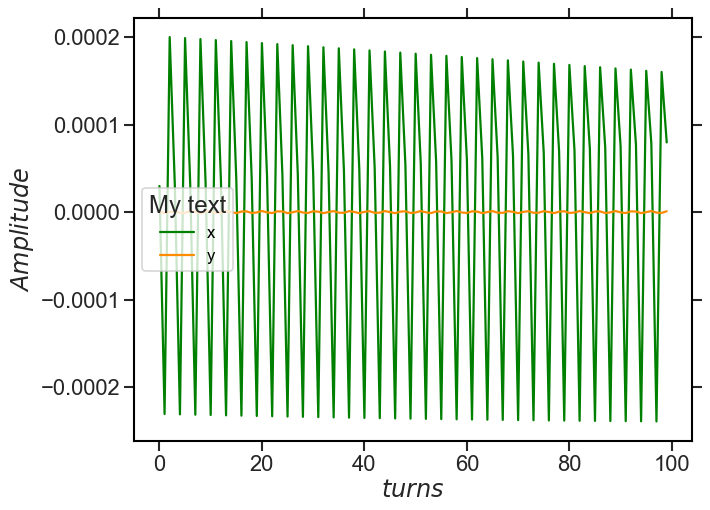

In [35]:
plt.figure(figsize=(9,7), dpi=80)
plt.plot(rec_x[2::npart][:100],label="x",color='green',linewidth=2)
plt.plot(rec_y[::npart][:100],label="y",color='darkorange',linewidth=2)
#legend_properties = {'weight':'bold'}
#plt.title("Title", fontweight="bold")
#plt.legend(title='My text',loc=6,fontsize='x-small',labelcolor='black', prop=legend_properties)
plt.legend(title='My text',loc=6,fontsize='x-small',labelcolor='black')
plt.xlabel("$turns$")
plt.ylabel("$Amplitude$")
#plt.xlim(0,1000)

Text(0, 0.5, '$x{\\prime}$ [rad]')

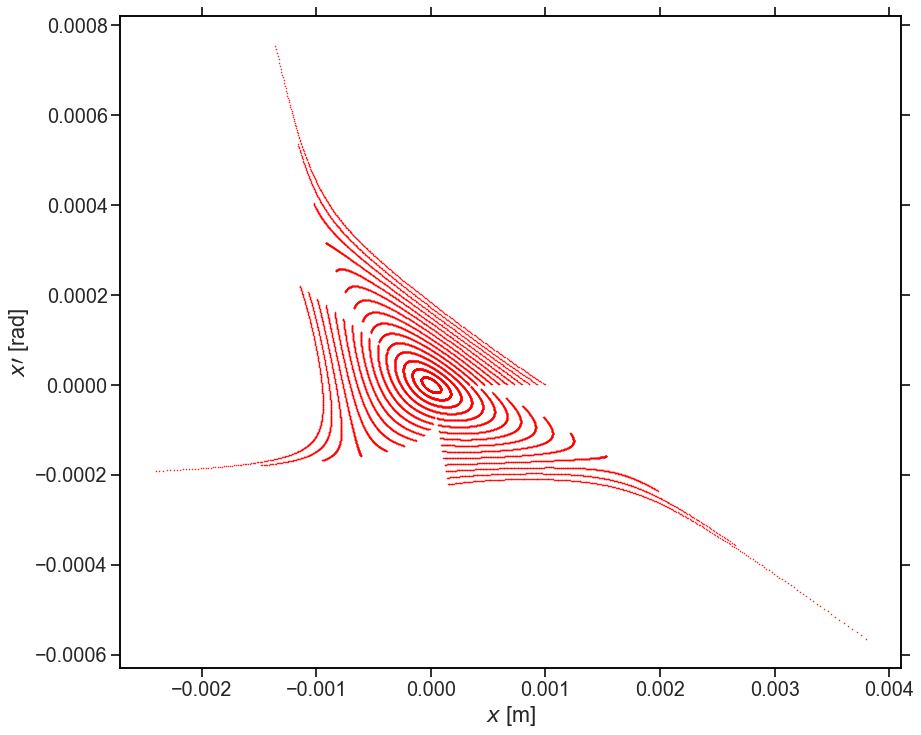

In [36]:
plt.figure(figsize=(14, 12))
plt.scatter(rec_x, rec_px, marker='.', s=1, c='red', edgecolor='red', linewidth=1)
#plt.title("Title", fontweight="bold")
plt.xlabel('$x$ [m]')
plt.ylabel('$x{\prime}$ [rad]')
#plt.text(-0.0025, -0.0006, 'Qx=4.333, Qy=3.29, npart=5, 1e-3, triplet on', dict(size=10))
#plt.xlim(-0.0005, 0.002)
#plt.ylim(-0.0005,0.0005)
#plt.gca().set_aspect(
#    np.diff(plt.xlim()) / np.diff(plt.ylim()))

Text(0, 0.5, '$p_y$ [μrad]')

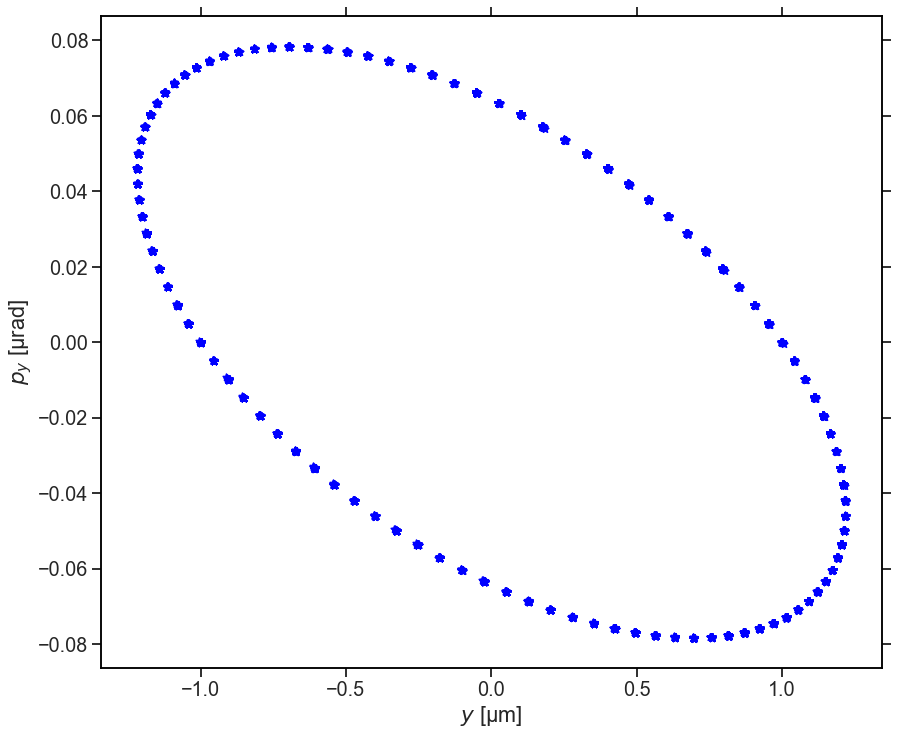

In [37]:
plt.figure(figsize=(14, 12))
plt.scatter(1e6 * rec_y, 1e6 * rec_py, marker='*', s=50, color='blue')
plt.xlabel('$y$ [μm]')
plt.ylabel('$p_y$ [μrad]')